In [124]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import rtree

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Event Listing

In [216]:
event_list_df = pd.read_csv("data/NYC_Parks_Events_Listing___Event_Listing.csv", parse_dates=True)

In [217]:
event_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68689 entries, 0 to 68688
Data columns (total 15 columns):
event_id                68689 non-null int64
title                   68689 non-null object
date                    68689 non-null object
start_time              68689 non-null object
end_time                68689 non-null object
location_description    13059 non-null object
description             68685 non-null object
snippet                 68385 non-null object
phone                   53482 non-null object
email                   47694 non-null object
cost_free               68689 non-null int64
cost_description        13807 non-null object
must_see                68689 non-null int64
url                     68687 non-null object
notice                  68689 non-null int64
dtypes: int64(4), object(11)
memory usage: 7.9+ MB


In [218]:
event_list_df['start_time'] = pd.to_datetime(event_list_df['start_time'], format='%H:%M')

In [219]:
event_list_df[event_list_df.end_time == '24:00']

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice
11088,79666,New Year's Eve Fireworks in Prospect Park,12/31/2013,1900-01-01 23:00:00,24:00,NaN,<p>\n\tStart the celebrations off around 11 p....,Start the celebrations off around 11 p.m. with...,NaN,NaN,1,NaN,1,new-years-eve-fireworks1,0
23359,102431,New Year's Eve Fireworks,12/31/2014,1900-01-01 23:00:00,24:00,NaN,<p>Kick off the New Year&#39;s with this belov...,Kick off the New Year's with this beloved Broo...,NaN,NaN,1,NaN,1,new-years-eve-fireworks,0


In [220]:
event_list_df = event_list_df.drop(event_list_df.index[23359])
event_list_df = event_list_df.drop(event_list_df.index[11088])

In [221]:
event_list_df[event_list_df.end_time == '24:00']

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice


In [222]:
event_list_df['end_time'] = pd.to_datetime(event_list_df['end_time'], format='%H:%M')

In [223]:
event_list_df['date'] = pd.to_datetime(event_list_df.date)

In [237]:
event_list_df['is_event'] = 1

In [224]:
event_list_df.end_time[40]

Timestamp('1900-01-01 15:00:00')

In [225]:
event_list_df.start_time[40]

Timestamp('1900-01-01 13:00:00')

In [226]:
event_list_df['event_duration'] = ((event_list_df.end_time-event_list_df.start_time).dt.total_seconds())/60

In [227]:
str(event_list_df.start_time.dt.time[0]).split(":")[0]

'11'

In [232]:
for index, event in event_list_df.iterrows():
    start = int(str(event_list_df.start_time.dt.time[index]).split(":")[0])
    end = int(str(event_list_df.end_time.dt.time[index]).split(":")[0])
    
    if(((start >= 3) & (start < 13)) | ((end >= 3) & (end < 13))):
        event_list_df.loc[[index],'morning'] = 1
    else:
        event_list_df.loc[[index],'morning'] = 0
        
    if(((start >= 13) & (start < 18)) | ((end >= 13) & (end < 18))):
        event_list_df.loc[[index],'afternoon'] = 1
    else:
        event_list_df.loc[[index],'afternoon'] = 0
        
    if(((start >= 18) & (start < 3)) | ((end >= 18) & (end < 3))):
        event_list_df.loc[[index],'night'] = 1
    else:
        event_list_df.loc[[index],'night'] = 0

KeyboardInterrupt: 

In [238]:
event_list_df.head()

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice,event_duration,morning,afternoon,night,is_event
0,62223,Bird Walks at The New York Botanical Garden,2013-01-05,1900-01-01 11:00:00,1900-01-01 12:00:00,Meets at reflecting pool.,<p>The diverse habitats of the Botanical Garde...,The diverse habitats of the Botanical Garden o...,718-817-8700,pubrel@nybg.org,0,Free with admission,0,bird-walks-at-the-new-york-botanical-garden,0,60.0,1.0,0.0,0.0,1
1,62224,Bird Walks at The New York Botanical Garden,2013-01-12,1900-01-01 11:00:00,1900-01-01 12:00:00,Meets at reflecting pool.,<p>The diverse habitats of the Botanical Garde...,The diverse habitats of the Botanical Garden o...,718-817-8700,pubrel@nybg.org,0,Free with admission,0,bird-walks-at-the-new-york-botanical-garden,0,60.0,1.0,0.0,0.0,1
2,62225,Bird Walks at The New York Botanical Garden,2013-01-19,1900-01-01 11:00:00,1900-01-01 12:00:00,Meets at reflecting pool.,<p>The diverse habitats of the Botanical Garde...,The diverse habitats of the Botanical Garden o...,718-817-8700,pubrel@nybg.org,0,Free with admission,0,bird-walks-at-the-new-york-botanical-garden,0,60.0,1.0,0.0,0.0,1
3,62226,Bird Walks at The New York Botanical Garden,2013-01-26,1900-01-01 11:00:00,1900-01-01 12:00:00,Meets at reflecting pool.,<p>The diverse habitats of the Botanical Garde...,The diverse habitats of the Botanical Garden o...,718-817-8700,pubrel@nybg.org,0,Free with admission,0,bird-walks-at-the-new-york-botanical-garden,0,60.0,1.0,0.0,0.0,1
4,62227,Bird Walks at The New York Botanical Garden,2013-02-02,1900-01-01 11:00:00,1900-01-01 12:00:00,Meets at reflecting pool.,<p>The diverse habitats of the Botanical Garde...,The diverse habitats of the Botanical Garden o...,718-817-8700,pubrel@nybg.org,0,Free with admission,0,bird-walks-at-the-new-york-botanical-garden,0,60.0,1.0,0.0,0.0,1


In [245]:
agg_df = event_list_df[event_list_df.date.dt.year == 2017]

In [162]:
agg_df.head()

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice,event_duration
26877,107941,Conference House Art Expo 2017,2017-05-20,1900-01-01 11:00:00,1900-01-01 17:00:00,NaN,<p>Come view original artworks and tree instal...,Come view original artworks and tree installat...,(718) 984-6046,admin@conferencehouse.org,1,NaN,0,resiliency-and-elements,0,360.0
27651,108867,Thursday Evening Hours at the Merchant’s House...,2017-01-05,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,480.0
27652,108868,Thursday Evening Hours at the Merchant’s House...,2017-01-12,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,480.0
27653,108869,Thursday Evening Hours at the Merchant’s House...,2017-01-19,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,480.0
27654,108870,Thursday Evening Hours at the Merchant’s House...,2017-01-26,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,480.0


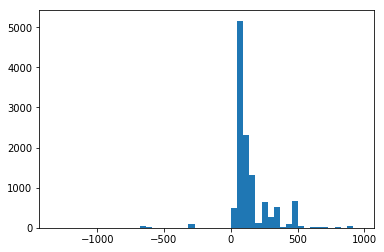

In [165]:
plt.hist(agg_df.event_duration, bins=50);

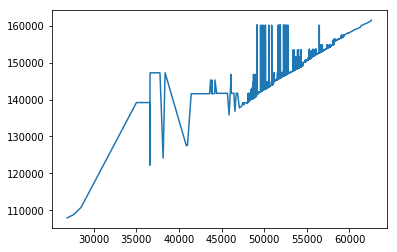

In [12]:
plt.plot(agg_df.event_id);

## Event Location

In [246]:
loc_df = pd.read_csv('data/NYC_Parks_Events_Listing___Event_Locations.csv')

In [247]:
loc_df.head()

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
0,62223,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
1,62224,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
2,62225,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
3,62226,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"
4,62227,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"


In [248]:
loc_df.shape

(87092, 10)

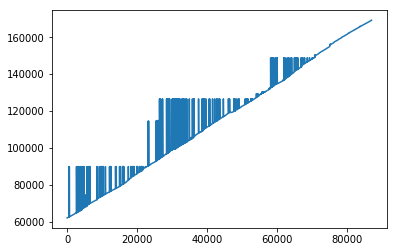

In [249]:
plt.plot(loc_df.event_id)

In [250]:
loc_df[loc_df.event_id == 141581]

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
65098,141581,Gracie Mansion,M081,40.776001,-73.9431,"88th Street & East End Avenue, Carl Schurz Park",10007.0,M,NaN,"(40.77600097656250000, -73.94309997558594000)"


In [251]:
loc_df[loc_df.event_id == 62223]

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1
0,62223,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)"


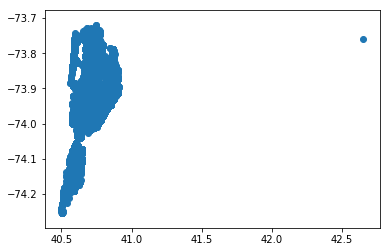

In [252]:
plt.scatter(loc_df.lat, loc_df.long)

https://towardsdatascience.com/geospatial-operations-at-scale-with-dask-and-geopandas-4d92d00eb7e8

In [253]:
df = gpd.read_file('data/taxizones/taxi_zones.shp').to_crs({'init': 'epsg:4326'})
df = df.drop(['Shape_Area', 'Shape_Leng', 'OBJECTID'], axis=1)
gpd.sjoin(gpd.GeoDataFrame(crs={'init': 'epsg:4326'},
    geometry=[Point(-73.9431, 40.776001)]), 
    df, how='left', op='within')

,geometry,index_right,zone,LocationID,borough
0,POINT (-73.9431 40.776001),261,Yorkville East,262,Manhattan


In [254]:
def assign_taxi_zones(df, lon_var, lat_var, locid_var):
    """Joins DataFrame with Taxi Zones shapefile.
    This function takes longitude values provided by `lon_var`, and latitude
    values provided by `lat_var` in DataFrame `df`, and performs a spatial join
    with the NYC taxi_zones shapefile. 
    The shapefile is hard coded in, as this function makes a hard assumption of
    latitude and longitude coordinates. It also assumes latitude=0 and 
    longitude=0 is not a datapoint that can exist in your dataset. Which is 
    reasonable for a dataset of New York, but bad for a global dataset.
    Only rows where `df.lon_var`, `df.lat_var` are reasonably near New York,
    and `df.locid_var` is set to np.nan are updated. 
    Parameters
    ----------
    df : pandas.DataFrame or dask.DataFrame
        DataFrame containing latitudes, longitudes, and location_id columns.
    lon_var : string
        Name of column in `df` containing longitude values. Invalid values 
        should be np.nan.
    lat_var : string
        Name of column in `df` containing latitude values. Invalid values 
        should be np.nan
    locid_var : string
        Name of series to return. 
    """

    import geopandas
    from shapely.geometry import Point


    # make a copy since we will modify lats and lons
    localdf = df[[lon_var, lat_var]].copy()
    
    # missing lat lon info is indicated by nan. Fill with zero
    # which is outside New York shapefile. 
    localdf[lon_var] = localdf[lon_var].fillna(value=0.)
    localdf[lat_var] = localdf[lat_var].fillna(value=0.)
    

    shape_df = geopandas.read_file('data/taxizones/taxi_zones.shp')
    shape_df.drop(['OBJECTID', "Shape_Area", "Shape_Leng", "borough", "zone"],
                  axis=1, inplace=True)
    shape_df = shape_df.to_crs({'init': 'epsg:4326'})

    try:
        local_gdf = geopandas.GeoDataFrame(
            localdf, crs={'init': 'epsg:4326'},
            geometry=[Point(xy) for xy in
                      zip(localdf[lon_var], localdf[lat_var])])

        local_gdf = geopandas.sjoin(
            local_gdf, shape_df, how='left', op='within')
#         return local_gdf
        return local_gdf.LocationID.rename(locid_var)
    except ValueError as ve:
        print(ve)
        print(ve.stacktrace())
        series = localdf[lon_var]
        series = np.nan
    return series

In [255]:
loc_df['taxi_zone'] = assign_taxi_zones(loc_df, 'long', 'lat', 'taxi_zones')

In [256]:
loc_df[loc_df.taxi_zone == np.inf]

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone


In [257]:
loc_df['taxi_zone'] = loc_df.taxi_zone.fillna(0).astype(int)

In [258]:
loc_df.head()

,event_id,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone
0,62223,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
1,62224,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
2,62225,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
3,62226,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31
4,62227,Watson Building,X002,40.8624,-73.880501,NaN,NaN,X,NaN,"(40.86240005493164000, -73.88050079345703000)",31


## Merge Event and Event Locations and Taxi

In [259]:
merged_df = pd.merge(agg_df, loc_df, on=['event_id'])

In [260]:
merged_df.head()

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice,event_duration,morning,afternoon,night,is_event,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone
0,107941,Conference House Art Expo 2017,2017-05-20,1900-01-01 11:00:00,1900-01-01 17:00:00,NaN,<p>Come view original artworks and tree instal...,Come view original artworks and tree installat...,(718) 984-6046,admin@conferencehouse.org,1,NaN,0,resiliency-and-elements,0,360.0,NaN,NaN,NaN,1,Conference House Park Visitor Center,R006,40.502602,-74.251801,298 Satterlee Street,NaN,R,1.0,"(40.50260162353500000, -74.25180053710900000)",44
1,108867,Thursday Evening Hours at the Merchant’s House...,2017-01-05,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,480.0,NaN,NaN,NaN,1,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113
2,108868,Thursday Evening Hours at the Merchant’s House...,2017-01-12,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,480.0,NaN,NaN,NaN,1,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113
3,108869,Thursday Evening Hours at the Merchant’s House...,2017-01-19,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,480.0,NaN,NaN,NaN,1,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113
4,108870,Thursday Evening Hours at the Merchant’s House...,2017-01-26,1900-01-01 12:00:00,1900-01-01 20:00:00,NaN,"<p>Beginning May 7, 2015, the Merchant’s House...","Beginning May 7, 2015, the Merchant’s House Mu...",(212) 777-1089,emily@merchantshouse.org,0,"Admission is $10, $5 seniors & students, Free ...",0,thursday-evening-hours-at-the-merchants-house-...,0,480.0,NaN,NaN,NaN,1,Merchant's House Museum,M318,40.727699,-73.992302,29 East 4th Street,10003.0,M,0.0,"(40.72769927978515600, -73.99230194091797000)",113


In [261]:
merged_df['date'] = pd.to_datetime(merged_df.date).dt.date

In [262]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12043 entries, 0 to 12042
Data columns (total 30 columns):
event_id                12043 non-null int64
title                   12043 non-null object
date                    12043 non-null object
start_time              12043 non-null datetime64[ns]
end_time                12043 non-null datetime64[ns]
location_description    2392 non-null object
description             12043 non-null object
snippet                 12039 non-null object
phone                   8745 non-null object
email                   8151 non-null object
cost_free               12043 non-null int64
cost_description        1953 non-null object
must_see                12043 non-null int64
url                     12041 non-null object
notice                  12043 non-null int64
event_duration          12043 non-null float64
morning                 0 non-null float64
afternoon               0 non-null float64
night                   0 non-null float64
is_event         

In [278]:
data = merged_df.merge(taxi_df, on=['date', 'taxi_zone'], how='right')

In [281]:
data.isnull().sum()

event_id                  9192
title                     9192
date                         0
start_time                9192
end_time                  9192
location_description     10236
description               9192
snippet                   9192
phone                     9550
email                     9555
cost_free                 9192
cost_description         10305
must_see                  9192
url                       9192
notice                    9192
event_duration            9192
morning                  10483
afternoon                10483
night                    10483
is_event                     0
name                      9192
park_id                   9400
lat                       9192
long                      9192
address                   9861
zip                       9710
borough                   9208
accessible                9845
Location 1                9192
taxi_zone                    0
VendorID                     0
lpep_pickup_datetime         0
lpep_dro

In [280]:
data.is_event.isnull().sum()

0

In [279]:
data['is_event'] = data.is_event.fillna(0)

In [272]:
data.head()

,event_id,title,date,start_time,end_time,location_description,description,snippet,phone,email,cost_free,cost_description,must_see,url,notice,event_duration,morning,afternoon,night,is_event,name,park_id,lat,long,address,zip,borough,accessible,Location 1,taxi_zone,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,taxi_duration
0,107941.0,Conference House Art Expo 2017,2017-05-20,1900-01-01 11:00:00,1900-01-01 17:00:00,NaN,<p>Come view original artworks and tree instal...,Come view original artworks and tree installat...,(718) 984-6046,admin@conferencehouse.org,1.0,NaN,0.0,resiliency-and-elements,0.0,360.0,NaN,NaN,NaN,1.0,Conference House Park Visitor Center,R006,40.502602,-74.251801,298 Satterlee Street,NaN,R,1.0,"(40.50260162353500000, -74.25180053710900000)",44,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,110805.0,For The Birds Festival: A Celebration of All T...,2017-05-20,1900-01-01 11:00:00,1900-01-01 16:00:00,NaN,<p>Come discover and celebrate NYC&#39;s avian...,Come discover and celebrate NYC's avian reside...,(718) 227-1463,john.kilcullen@parks.nyc.gov,1.0,NaN,1.0,for-the-birds-festivala-celebration-of-all-thi...,0.0,300.0,NaN,NaN,NaN,1.0,Conference House Park Visitor Center,R006,40.502602,-74.251801,298 Satterlee Street,NaN,R,1.0,"(40.50260162353500000, -74.25180053710900000)",44,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,139848.0,Shape Up NYC: Mind Body Fusion,2017-05-20,1900-01-01 09:00:00,1900-01-01 10:00:00,Meet at the Conference House kitchen.,<p>This class features a low-impact cardio wor...,This class features a low-impact cardio workou...,(718) 227-1463,sigona99@verizon.net,1.0,NaN,0.0,shape-up-nyc-mind-body-fusion,0.0,60.0,NaN,NaN,NaN,1.0,Conference House Museum,R006,40.501999,-74.251404,298 Satterlee Street,10307.0,R,1.0,"(40.50199890136719000, -74.25140380859375000)",44,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,145112.0,It's My Park at Conference House Park,2017-05-20,1900-01-01 10:00:00,1900-01-01 12:00:00,NaN,<p>Volunteer this It&#39;s My Park season with...,Volunteers will help with gardening preparatio...,(718) 227-1463,John.kilcullen@parks.nyc.gov,1.0,NaN,0.0,its-my-park-at-conference-house-park,0.0,120.0,NaN,NaN,NaN,1.0,Conference House Park Visitor Center,R006,40.502602,-74.251801,298 Satterlee Street,NaN,R,1.0,"(40.50260162353500000, -74.25180053710900000)",44,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,146303.0,It's My Park at Conference House Park,2017-05-20,1900-01-01 09:00:00,1900-01-01 12:00:00,Volunteers should meet at the parking lot at t...,"<p>This It&#39;s My Park season, volunteer wit...","This It's My Park season, volunteer with Natur...",(718) 873-4291,nrpa2@aol.com,1.0,NaN,0.0,its-my-park-at-conference-house-park,0.0,180.0,NaN,NaN,NaN,1.0,Page Avenue Beach Parking Lot,NaN,40.502624,-74.227903,At the foot of Page Avenue,NaN,R,1.0,"(40.50262374137300000, -74.22790294885600000)",44,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [287]:
# data.groupby(['date', 'taxi_zone', 'is_event'])[['trip_distance']].mean()

In [236]:
# data.groupby(['date', 'taxi_zone']).count()

In [291]:
data.groupby(['is_event', 'taxi_zone'])[['VendorID']].count()

VendorID
is_event taxi_zone          
0.0      1                 8
         3                 8
         4                11
         7               265
         8                 1
         9                 7
         10               16
         11                2
         12                1
         13               17
         14               24
         15                3
         16                3
         17              129
         18                4
         19                2
         20               10
         21                6
         22                4
         24               41
         25              109
         26               11
         28               31
         29                7
         31                1
         32                2
         33               75
         34               13
         35               21
         36               52
         37               77
         38                1
         39                8
         40               74
         41              302
         42              301
         45               17
         47               18
         48               42
         49              148
         50               13
         51                6
         52               46
         53               12
         54               20
         55                9
         56               93
         57                6
         60                6
         61              143
         62               33
         63               11
         65               86
         66               59
         67                2
         68               24
         69               42
         70               53
         71               11
         72               10
         73                7
         74              278
         75              229
         76               25
         77                7
         78               14
         79               47
         80               85
         81                4
         82              201
         83               68
         85               17
         87               16
         88               12
         89               49
         90               15
         91                8
         92               20
         93               10
         94               12
         95              146
         96                1
         97              132
         98                7
         100              12
         101               2
         102              18
         106              40
         107              18
         108               7
         111               1
         112             150
         113              14
         114              18
         115               1
         116             107
         117               1
         119              19
         120               3
         121              31
         122               5
         123               7
         124               3
         125               8
         126               9
         127              28
         128               2
         129             258
         130              43
         131              15
         132              56
         133              20
         134              39
         135              33
         136              12
         137              24
         138             129
         139               5
         140              51
         141              53
         142              66
         143              19
         144              29
         145              85
         146              51
         147               7
         148              30
         149               3
         150               4
         151              97
         152              62
         153               6
         154               2
         155               4
         156               1
         157              60
         158      

In [ ]:
# map_df = gpd.read_file('data/newyorkzonemap/geo_export_83da3a04-bfe1-4338-bd66-aa8fff31dec0.shp')

In [ ]:
# map_df.plot()

## Taxi Trip Data

In [26]:
import random

filename = "data/2017_Green_Taxi_Trip_Data.csv"
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 10000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
taxi_df = pd.read_csv(filename, skiprows=skip)

In [27]:
# taxi_df = pd.read_csv('2017_Green_Taxi_Trip_Data.csv', nrows=10000)

In [28]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
VendorID                 10000 non-null int64
lpep_pickup_datetime     10000 non-null object
lpep_dropoff_datetime    10000 non-null object
store_and_fwd_flag       10000 non-null object
RatecodeID               10000 non-null int64
PULocationID             10000 non-null int64
DOLocationID             10000 non-null int64
passenger_count          10000 non-null int64
trip_distance            10000 non-null float64
fare_amount              10000 non-null float64
extra                    10000 non-null float64
mta_tax                  10000 non-null float64
tip_amount               10000 non-null float64
tolls_amount             10000 non-null float64
ehail_fee                0 non-null float64
improvement_surcharge    10000 non-null float64
total_amount             10000 non-null float64
payment_type             10000 non-null int64
trip_type                10000 non-null int64
d

In [29]:
taxi_df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type
0,2,01/01/2017 12:00:22 AM,01/01/2017 12:06:58 AM,N,1,61,225,3,1.84,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2,1
1,2,01/01/2017 12:59:29 AM,01/01/2017 01:06:22 AM,N,1,7,223,1,1.26,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2,1
2,2,01/01/2017 01:33:13 AM,01/01/2017 01:40:13 AM,N,1,264,70,5,1.88,8.5,0.5,0.5,0.00,0.0,NaN,0.3,9.80,2,1
3,2,01/01/2017 01:29:56 AM,01/01/2017 01:50:35 AM,N,1,256,106,1,7.29,23.0,0.5,0.5,0.00,0.0,NaN,0.3,24.30,1,1
4,2,01/01/2017 01:54:23 AM,01/01/2017 02:13:07 AM,N,1,255,125,1,3.93,16.0,0.5,0.5,3.46,0.0,NaN,0.3,20.76,1,1


In [30]:
taxi_df['lpep_pickup_datetime'] = pd.to_datetime(taxi_df.lpep_pickup_datetime)

In [31]:
taxi_df['lpep_dropoff_datetime'] = pd.to_datetime(taxi_df.lpep_dropoff_datetime)

In [32]:
taxi_df['date'] = taxi_df.lpep_pickup_datetime.dt.date

In [146]:
taxi_df['taxi_duration'] = ((taxi_df.lpep_dropoff_datetime - taxi_df.lpep_pickup_datetime).dt.total_seconds())//60

In [147]:
taxi_df = taxi_df.rename(columns={'DOLocationID' : 'taxi_zone'})

In [148]:
taxi_df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,taxi_zone,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,date,taxi_duration
0,2,2017-01-01 00:00:22,2017-01-01 00:06:58,N,1,61,225,3,1.84,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2,1,2017-01-01,6.0
1,2,2017-01-01 00:59:29,2017-01-01 01:06:22,N,1,7,223,1,1.26,7.0,0.5,0.5,0.00,0.0,NaN,0.3,8.30,2,1,2017-01-01,6.0
2,2,2017-01-01 01:33:13,2017-01-01 01:40:13,N,1,264,70,5,1.88,8.5,0.5,0.5,0.00,0.0,NaN,0.3,9.80,2,1,2017-01-01,7.0
3,2,2017-01-01 01:29:56,2017-01-01 01:50:35,N,1,256,106,1,7.29,23.0,0.5,0.5,0.00,0.0,NaN,0.3,24.30,1,1,2017-01-01,20.0
4,2,2017-01-01 01:54:23,2017-01-01 02:13:07,N,1,255,125,1,3.93,16.0,0.5,0.5,3.46,0.0,NaN,0.3,20.76,1,1,2017-01-01,18.0


In [35]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
VendorID                 10000 non-null int64
lpep_pickup_datetime     10000 non-null datetime64[ns]
lpep_dropoff_datetime    10000 non-null datetime64[ns]
store_and_fwd_flag       10000 non-null object
RatecodeID               10000 non-null int64
PULocationID             10000 non-null int64
taxi_zone                10000 non-null int64
passenger_count          10000 non-null int64
trip_distance            10000 non-null float64
fare_amount              10000 non-null float64
extra                    10000 non-null float64
mta_tax                  10000 non-null float64
tip_amount               10000 non-null float64
tolls_amount             10000 non-null float64
ehail_fee                0 non-null float64
improvement_surcharge    10000 non-null float64
total_amount             10000 non-null float64
payment_type             10000 non-null int64
trip_type                10000 

In [36]:
type(pd.to_datetime(taxi_df.date)[0])

pandas._libs.tslibs.timestamps.Timestamp